# Helper modules

In [1]:
!pip install -U tqdm pillow matplotlib

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.23.4)
Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (5.1.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (2.2.2)
Requirement not upgraded as not directly required: python-dateutil>=2.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (2.5.3)
Requirement not upgraded as not directly required: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (2.2.0)
Requirement not upgraded as not directly required: kiwisolver>=1.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (1.0.1)
Requirement not upgraded as not directly required: cycler>=0.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (0.10.0)
Requirement not upgraded as not directly required: numpy>=1.7.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (1.14.3)
Requirement not upgraded as

In [0]:
import math
import os
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm


def _read32(bytestream):
    """
    Read 32-bit integer from bytesteam
    :param bytestream: A bytestream
    :return: 32-bit integer
    """
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)


def _ungzip(save_path, extract_path, database_name, _):
    """
    Unzip a gzip file and extract it to extract_path
    :param save_path: The path of the gzip files
    :param extract_path: The location to extract the data to
    :param database_name: Name of database
    :param _: HACK - Used to have to same interface as _unzip
    """
    # Get data from save_path
    with open(save_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    # Save data to extract_path
    for image_i, image in enumerate(
            tqdm(data, unit='File', unit_scale=True, miniters=1, desc='Extracting {}'.format(database_name))):
        Image.fromarray(image, 'L').save(os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))

class helper:
  def get_image(image_path, width, height, mode):
      """
      Read image from image_path
      :param image_path: Path of image
      :param width: Width of image
      :param height: Height of image
      :param mode: Mode of image
      :return: Image data
      """
      image = Image.open(image_path)

      if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
          # Remove most pixels that aren't part of a face
          face_width = face_height = 108
          j = (image.size[0] - face_width) // 2
          i = (image.size[1] - face_height) // 2
          image = image.crop([j, i, j + face_width, i + face_height])
          image = image.resize([width, height], Image.BILINEAR)

      return np.array(image.convert(mode))


  def get_batch(image_files, width, height, mode):
      data_batch = np.array(
          [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

      # Make sure the images are in 4 dimensions
      if len(data_batch.shape) < 4:
          data_batch = data_batch.reshape(data_batch.shape + (1,))

      return data_batch


  def images_square_grid(images, mode):
      """
      Save images as a square grid
      :param images: Images to be used for the grid
      :param mode: The mode to use for images
      :return: Image of images in a square grid
      """
      # Get maximum size for square grid of images
      save_size = math.floor(np.sqrt(images.shape[0]))

      # Scale to 0-255
      images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

      # Put images in a square arrangement
      images_in_square = np.reshape(
              images[:save_size*save_size],
              (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
      if mode == 'L':
          images_in_square = np.squeeze(images_in_square, 4)

      # Combine images to grid image
      new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
      for col_i, col_images in enumerate(images_in_square):
          for image_i, image in enumerate(col_images):
              im = Image.fromarray(image, mode)
              new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

      return new_im


  def download_extract(database_name, data_path):
      """
      Download and extract database
      :param database_name: Database name
      """
      DATASET_CELEBA_NAME = 'celeba'
      DATASET_MNIST_NAME = 'mnist'

      if database_name == DATASET_CELEBA_NAME:
          url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
          hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
          extract_path = os.path.join(data_path, 'img_align_celeba')
          save_path = os.path.join(data_path, 'celeba.zip')
          extract_fn = _unzip
      elif database_name == DATASET_MNIST_NAME:
          url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
          hash_code = 'f68b3c2dcbeaaa9fbdd348bbdeb94873'
          extract_path = os.path.join(data_path, 'mnist')
          save_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
          extract_fn = _ungzip

      if os.path.exists(extract_path):
          print('Found {} Data'.format(database_name))
          return

      if not os.path.exists(data_path):
          os.makedirs(data_path)

      if not os.path.exists(save_path):
          with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
              urlretrieve(
                  url,
                  save_path,
                  pbar.hook)

      assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
          '{} file is corrupted.  Remove the file and try again.'.format(save_path)

      os.makedirs(extract_path)
      try:
          extract_fn(save_path, extract_path, database_name, data_path)
      except Exception as err:
          shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
          raise err

      # Remove compressed data
      os.remove(save_path)


  class Dataset(object):
      """
      Dataset
      """
      def __init__(self, dataset_name, data_files):
          """
          Initalize the class
          :param dataset_name: Database name
          :param data_files: List of files in the database
          """
          DATASET_CELEBA_NAME = 'celeba'
          DATASET_MNIST_NAME = 'mnist'
          IMAGE_WIDTH = 28
          IMAGE_HEIGHT = 28

          if dataset_name == DATASET_CELEBA_NAME:
              self.image_mode = 'RGB'
              image_channels = 3

          elif dataset_name == DATASET_MNIST_NAME:
              self.image_mode = 'L'
              image_channels = 1

          self.data_files = data_files
          self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

      def get_batches(self, batch_size):
          """
          Generate batches
          :param batch_size: Batch Size
          :return: Batches of data
          """
          IMAGE_MAX_VALUE = 255

          current_index = 0
          while current_index + batch_size <= self.shape[0]:
              data_batch = helper.get_batch(
                  self.data_files[current_index:current_index + batch_size],
                  *self.shape[1:3],
                  self.image_mode)

              current_index += batch_size

              yield data_batch / IMAGE_MAX_VALUE - 0.5


  class DLProgress(tqdm):
      """
      Handle Progress Bar while Downloading
      """
      last_block = 0

      def hook(self, block_num=1, block_size=1, total_size=None):
          """
          A hook function that will be called once on establishment of the network connection and
          once after each block read thereafter.
          :param block_num: A count of blocks transferred so far
          :param block_size: Block size in bytes
          :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                              a file size in response to a retrieval request.
          """
          self.total = total_size
          self.update((block_num - self.last_block) * block_size)
          self.last_block = block_num

get_image = helper.get_image
Dataset = helper.Dataset
DLProgress = helper.DLProgress


from copy import deepcopy
from unittest import mock
import tensorflow as tf


def test_safe(func):
    """
    Isolate tests
    """
    def func_wrapper(*args):
        with tf.Graph().as_default():
            result = func(*args)
        print('Tests Passed')
        return result

    return func_wrapper


def _assert_tensor_shape(tensor, shape, display_name):
    assert tf.assert_rank(tensor, len(shape), message='{} has wrong rank'.format(display_name))

    tensor_shape = tensor.get_shape().as_list() if len(shape) else []

    wrong_dimension = [ten_dim for ten_dim, cor_dim in zip(tensor_shape, shape)
                       if cor_dim is not None and ten_dim != cor_dim]
    assert not wrong_dimension, \
        '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)


def _check_input(tensor, shape, display_name, tf_name=None):
    assert tensor.op.type == 'Placeholder', \
        '{} is not a Placeholder.'.format(display_name)

    _assert_tensor_shape(tensor, shape, 'Real Input')

    if tf_name:
        assert tensor.name == tf_name, \
            '{} has bad name.  Found name {}'.format(display_name, tensor.name)


class TmpMock():
    """
    Mock a attribute.  Restore attribute when exiting scope.
    """
    def __init__(self, module, attrib_name):
        self.original_attrib = deepcopy(getattr(module, attrib_name))
        setattr(module, attrib_name, mock.MagicMock())
        self.module = module
        self.attrib_name = attrib_name

    def __enter__(self):
        return getattr(self.module, self.attrib_name)

    def __exit__(self, type, value, traceback):
        setattr(self.module, self.attrib_name, self.original_attrib)

class tests:
  TmpMock = TmpMock
  
  @test_safe
  def test_model_inputs(model_inputs):
      image_width = 28
      image_height = 28
      image_channels = 3
      z_dim = 100
      input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)

      _check_input(input_real, [None, image_width, image_height, image_channels], 'Real Input')
      _check_input(input_z, [None, z_dim], 'Z Input')
      _check_input(learn_rate, [], 'Learning Rate')


  @test_safe
  def test_discriminator(discriminator, tf_module):
      with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
          image = tf.placeholder(tf.float32, [None, 28, 28, 3])

          output, logits = discriminator(image)
          _assert_tensor_shape(output, [None, 1], 'Discriminator Training(reuse=false) output')
          _assert_tensor_shape(logits, [None, 1], 'Discriminator Training(reuse=false) Logits')
          assert mock_variable_scope.called,\
              'tf.variable_scope not called in Discriminator Training(reuse=false)'
          assert mock_variable_scope.call_args == mock.call('discriminator', reuse=False), \
              'tf.variable_scope called with wrong arguments in Discriminator Training(reuse=false)'

          mock_variable_scope.reset_mock()

          output_reuse, logits_reuse = discriminator(image, True)
          _assert_tensor_shape(output_reuse, [None, 1], 'Discriminator Inference(reuse=True) output')
          _assert_tensor_shape(logits_reuse, [None, 1], 'Discriminator Inference(reuse=True) Logits')
          assert mock_variable_scope.called, \
              'tf.variable_scope not called in Discriminator Inference(reuse=True)'
          assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True), \
              'tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)'


  @test_safe
  def test_generator(generator, tf_module):
      with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
          z = tf.placeholder(tf.float32, [None, 100])
          out_channel_dim = 5

          output = generator(z, out_channel_dim)
          _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=True)')
          assert mock_variable_scope.called, \
              'tf.variable_scope not called in Generator Training(reuse=false)'
          assert mock_variable_scope.call_args == mock.call('generator', reuse=False), \
              'tf.variable_scope called with wrong arguments in Generator Training(reuse=false)'

          mock_variable_scope.reset_mock()
          output = generator(z, out_channel_dim, False)
          _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=False)')
          assert mock_variable_scope.called, \
              'tf.variable_scope not called in Generator Inference(reuse=True)'
          assert mock_variable_scope.call_args == mock.call('generator', reuse=True), \
              'tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)'


  @test_safe
  def test_model_loss(model_loss):
      out_channel_dim = 4
      input_real = tf.placeholder(tf.float32, [None, 28, 28, out_channel_dim])
      input_z = tf.placeholder(tf.float32, [None, 100])

      d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)

      _assert_tensor_shape(d_loss, [], 'Discriminator Loss')
      _assert_tensor_shape(g_loss, [], 'Generator Loss')


  @test_safe
  def test_model_opt(model_opt, tf_module):
      with TmpMock(tf_module, 'trainable_variables') as mock_trainable_variables:
          with tf.variable_scope('discriminator'):
              discriminator_logits = tf.Variable(tf.zeros([3, 3]))
          with tf.variable_scope('generator'):
              generator_logits = tf.Variable(tf.zeros([3, 3]))

          mock_trainable_variables.return_value = [discriminator_logits, generator_logits]
          d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
              logits=discriminator_logits,
              labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
          g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
              logits=generator_logits,
              labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
          learning_rate = 0.001
          beta1 = 0.9

          d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
          assert mock_trainable_variables.called,\
              'tf.mock_trainable_variables not called'

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
#import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

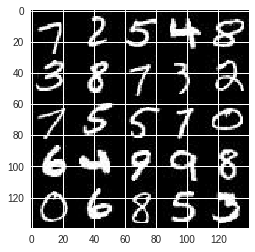

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

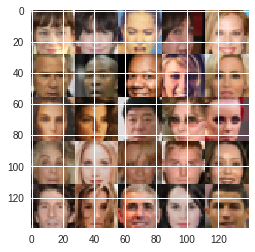

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
#import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(
        tf.float32,
        shape=(None, image_width, image_height, image_channels),
        name='input_real')
    input_z = tf.placeholder(
        tf.float32,
        shape=(None, z_dim),
        name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        c = images
        # 28 x 28 x 3

        c = tf.layers.conv2d(c, filters=64, kernel_size=5, strides=2, padding='same')
        c = tf.nn.leaky_relu(c, alpha=alpha)
        # 14 x 14 x 64

        c = tf.layers.conv2d(c, filters=128, kernel_size=5, strides=2, padding='same')
        c = tf.layers.batch_normalization(c, training=True)
        c = tf.nn.leaky_relu(c, alpha=alpha)
        # 7 x 7 x 128

        c = tf.layers.conv2d(c, filters=256, kernel_size=5, strides=2, padding='same')
        c = tf.layers.batch_normalization(c, training=True)
        c = tf.nn.leaky_relu(c, alpha=alpha)
        # 4 x 4 x 256

        c = tf.reshape(c, shape=(-1, 4*4*256))

        logits = tf.layers.dense(c, 1)
        outputs = tf.sigmoid(logits)

    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    print_shape = not True
    with tf.variable_scope('generator', reuse=(not is_train)):
        # project and reshape
        x = tf.layers.dense(z, 7*7*1024)
        x = tf.reshape(x, shape=(-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=alpha)
        if print_shape: print('project:', x.shape)

        # out: 14 x 14 x 256
        x = tf.layers.conv2d_transpose(x, filters=256, kernel_size=5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=alpha)
        if print_shape: print('conv1:', x.shape)
        
        # out: 28 x 28 x 128
        x = tf.layers.conv2d_transpose(x, filters=128, kernel_size=5, strides=2, padding='same')
        x = tf.tanh(x)
        if print_shape: print('conv3:', x.shape)
        
        # out: 28 x 28 x out_channel_dim
        x = tf.layers.conv2d_transpose(x, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        if print_shape: print('conv4:', x.shape)
        
    return tf.tanh(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_fake_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_outputs, d_fake_logits = discriminator(g_fake_outputs, reuse=True)
    
    d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits) * 0.9)
    d_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits))
    #d_loss = tf.reduce_mean(tf.concat([d_real_loss, d_fake_loss], axis=0))
    d_loss = tf.reduce_mean(d_real_loss) + tf.reduce_mean(d_fake_loss)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    d_vars = tf.trainable_variables(scope='discriminator')
    g_vars = tf.trainable_variables(scope='generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
      g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
import pandas as pd

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    num_images, image_width, image_height, image_channels = data_shape
    num_batches = num_images // batch_size
    
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        d_loss_mavg = 0
        g_loss_mavg = 0
        for epoch_i in range(epoch_count):
            batch_i = 0
            mavg_alpha = 0.1
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, [batch_images.shape[0], z_dim])
                sess.run([d_opt], feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    learning_rate_ph: learning_rate
                })
                sess.run([g_opt], feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    learning_rate_ph: learning_rate
                })
                d_loss_val, g_loss_val = sess.run([d_loss, g_loss], feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })
                d_loss_mavg = mavg_alpha * d_loss_val + (1 - mavg_alpha) * d_loss_mavg
                g_loss_mavg = mavg_alpha * g_loss_val + (1 - mavg_alpha) * g_loss_mavg
                if batch_i % (num_batches // 20) == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if batch_i % (num_batches // 200) == 0:
                    print('Epoch {}/{}, {:.1f}%: d_loss={:.4f}, g_loss={:.4f}'.format(
                        epoch_i+1, epoch_count, (batch_i+1) / num_batches * 100, d_loss_mavg, g_loss_mavg))
                batch_i += 1

            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            print('Epoch {}/{}, {:.1f}%: d_loss={:.4f}, g_loss={:.4f}'.format(
                epoch_i+1, epoch_count, (batch_i+1) / num_batches * 100, d_loss_mavg, g_loss_mavg))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

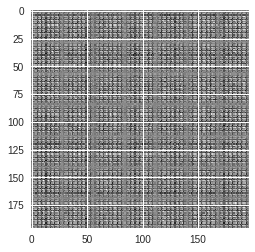

Epoch 1/2, 0.2%: d_loss=0.4904, g_loss=0.0016
Epoch 1/2, 0.6%: d_loss=0.6732, g_loss=0.2149
Epoch 1/2, 1.1%: d_loss=0.7606, g_loss=0.5096
Epoch 1/2, 1.5%: d_loss=0.7132, g_loss=0.9808
Epoch 1/2, 1.9%: d_loss=0.6979, g_loss=1.3444
Epoch 1/2, 2.4%: d_loss=0.6485, g_loss=1.8426
Epoch 1/2, 2.8%: d_loss=0.6208, g_loss=2.0483
Epoch 1/2, 3.2%: d_loss=0.5812, g_loss=2.3753
Epoch 1/2, 3.6%: d_loss=0.6476, g_loss=2.8349
Epoch 1/2, 4.1%: d_loss=0.7554, g_loss=2.8611
Epoch 1/2, 4.5%: d_loss=0.7844, g_loss=2.8313
Epoch 1/2, 4.9%: d_loss=0.8232, g_loss=2.5817


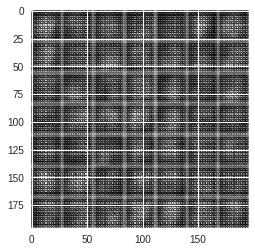

Epoch 1/2, 5.3%: d_loss=0.8368, g_loss=2.6354
Epoch 1/2, 5.8%: d_loss=0.7834, g_loss=2.6587
Epoch 1/2, 6.2%: d_loss=0.8030, g_loss=2.6054
Epoch 1/2, 6.6%: d_loss=0.8142, g_loss=2.7434
Epoch 1/2, 7.1%: d_loss=0.7813, g_loss=2.6507
Epoch 1/2, 7.5%: d_loss=0.8030, g_loss=2.4041
Epoch 1/2, 7.9%: d_loss=0.8668, g_loss=2.1677
Epoch 1/2, 8.3%: d_loss=0.9737, g_loss=2.0513
Epoch 1/2, 8.8%: d_loss=1.0263, g_loss=2.1233
Epoch 1/2, 9.2%: d_loss=0.9603, g_loss=2.0983
Epoch 1/2, 9.6%: d_loss=0.9082, g_loss=2.0379


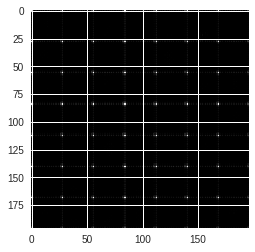

Epoch 1/2, 10.0%: d_loss=0.8561, g_loss=2.0022
Epoch 1/2, 10.5%: d_loss=0.8252, g_loss=1.9973
Epoch 1/2, 10.9%: d_loss=0.8678, g_loss=1.9464
Epoch 1/2, 11.3%: d_loss=0.9135, g_loss=1.9202
Epoch 1/2, 11.8%: d_loss=0.9535, g_loss=1.8868
Epoch 1/2, 12.2%: d_loss=0.9901, g_loss=1.7080
Epoch 1/2, 12.6%: d_loss=1.0761, g_loss=1.5503
Epoch 1/2, 13.0%: d_loss=1.1344, g_loss=1.5641
Epoch 1/2, 13.5%: d_loss=1.0631, g_loss=1.6887
Epoch 1/2, 13.9%: d_loss=1.0183, g_loss=1.6598
Epoch 1/2, 14.3%: d_loss=0.9978, g_loss=1.5892
Epoch 1/2, 14.7%: d_loss=0.9865, g_loss=1.5367


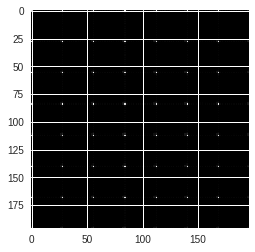

Epoch 1/2, 15.2%: d_loss=1.0149, g_loss=1.5426
Epoch 1/2, 15.6%: d_loss=1.0572, g_loss=1.5693
Epoch 1/2, 16.0%: d_loss=1.0346, g_loss=1.5017
Epoch 1/2, 16.5%: d_loss=1.0052, g_loss=1.4815
Epoch 1/2, 16.9%: d_loss=0.9808, g_loss=1.4659
Epoch 1/2, 17.3%: d_loss=0.9705, g_loss=1.4079
Epoch 1/2, 17.7%: d_loss=0.9867, g_loss=1.3702
Epoch 1/2, 18.2%: d_loss=1.0273, g_loss=1.4107
Epoch 1/2, 18.6%: d_loss=1.0032, g_loss=1.5018
Epoch 1/2, 19.0%: d_loss=0.9567, g_loss=1.5057
Epoch 1/2, 19.4%: d_loss=0.9380, g_loss=1.4914


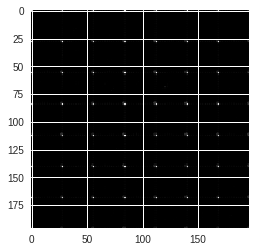

Epoch 1/2, 19.9%: d_loss=0.9181, g_loss=1.4926
Epoch 1/2, 20.3%: d_loss=0.8845, g_loss=1.4854
Epoch 1/2, 20.7%: d_loss=0.8575, g_loss=1.4924
Epoch 1/2, 21.2%: d_loss=0.8347, g_loss=1.5154
Epoch 1/2, 21.6%: d_loss=0.8193, g_loss=1.5647
Epoch 1/2, 22.0%: d_loss=0.8185, g_loss=1.5754
Epoch 1/2, 22.4%: d_loss=0.8307, g_loss=1.5657
Epoch 1/2, 22.9%: d_loss=0.9410, g_loss=1.6200
Epoch 1/2, 23.3%: d_loss=1.0066, g_loss=1.8508
Epoch 1/2, 23.7%: d_loss=0.9402, g_loss=1.9463
Epoch 1/2, 24.1%: d_loss=0.9531, g_loss=1.9334
Epoch 1/2, 24.6%: d_loss=0.9601, g_loss=1.9811


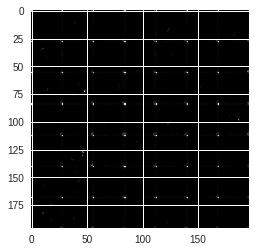

Epoch 1/2, 25.0%: d_loss=0.9054, g_loss=1.9108
Epoch 1/2, 25.4%: d_loss=0.8492, g_loss=1.9295
Epoch 1/2, 25.9%: d_loss=0.7910, g_loss=1.9839
Epoch 1/2, 26.3%: d_loss=0.7396, g_loss=2.0204
Epoch 1/2, 26.7%: d_loss=0.6976, g_loss=2.0470
Epoch 1/2, 27.1%: d_loss=0.6635, g_loss=2.0652
Epoch 1/2, 27.6%: d_loss=0.6404, g_loss=2.0630
Epoch 1/2, 28.0%: d_loss=0.6205, g_loss=2.0774
Epoch 1/2, 28.4%: d_loss=0.5974, g_loss=2.1284
Epoch 1/2, 28.8%: d_loss=0.5828, g_loss=2.1534
Epoch 1/2, 29.3%: d_loss=0.5640, g_loss=2.1721


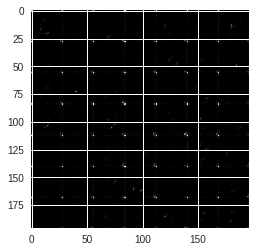

Epoch 1/2, 29.7%: d_loss=0.5492, g_loss=2.2118
Epoch 1/2, 30.1%: d_loss=0.5447, g_loss=2.1923
Epoch 1/2, 30.6%: d_loss=0.5373, g_loss=2.2167
Epoch 1/2, 31.0%: d_loss=0.5261, g_loss=2.2545
Epoch 1/2, 31.4%: d_loss=0.5161, g_loss=2.3047
Epoch 1/2, 31.8%: d_loss=0.5084, g_loss=2.3305
Epoch 1/2, 32.3%: d_loss=0.5081, g_loss=2.3302
Epoch 1/2, 32.7%: d_loss=0.5057, g_loss=2.3383
Epoch 1/2, 33.1%: d_loss=0.5103, g_loss=2.3770
Epoch 1/2, 33.5%: d_loss=0.5820, g_loss=2.4801
Epoch 1/2, 34.0%: d_loss=1.0907, g_loss=2.9543
Epoch 1/2, 34.4%: d_loss=1.1089, g_loss=2.5846


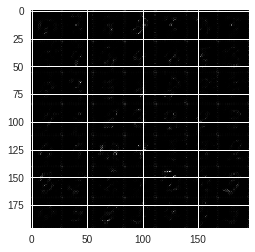

Epoch 1/2, 34.8%: d_loss=1.0349, g_loss=2.8480
Epoch 1/2, 35.3%: d_loss=0.9778, g_loss=2.7593
Epoch 1/2, 35.7%: d_loss=0.8948, g_loss=2.6323
Epoch 1/2, 36.1%: d_loss=0.8119, g_loss=2.6769
Epoch 1/2, 36.5%: d_loss=0.7488, g_loss=2.6295
Epoch 1/2, 37.0%: d_loss=0.6873, g_loss=2.6991
Epoch 1/2, 37.4%: d_loss=0.6666, g_loss=2.6528
Epoch 1/2, 37.8%: d_loss=0.6619, g_loss=2.8337
Epoch 1/2, 38.2%: d_loss=0.6361, g_loss=2.8340
Epoch 1/2, 38.7%: d_loss=0.6022, g_loss=2.7715
Epoch 1/2, 39.1%: d_loss=0.5720, g_loss=2.8041


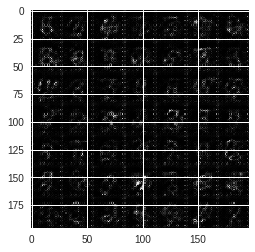

Epoch 1/2, 39.5%: d_loss=0.5508, g_loss=2.8244
Epoch 1/2, 40.0%: d_loss=0.5156, g_loss=3.1596
Epoch 1/2, 40.4%: d_loss=0.4938, g_loss=3.1671
Epoch 1/2, 40.8%: d_loss=0.4911, g_loss=3.0093
Epoch 1/2, 41.2%: d_loss=0.4734, g_loss=3.0425
Epoch 1/2, 41.7%: d_loss=0.4564, g_loss=3.1289
Epoch 1/2, 42.1%: d_loss=0.4485, g_loss=3.0958
Epoch 1/2, 42.5%: d_loss=0.4332, g_loss=3.2987
Epoch 1/2, 42.9%: d_loss=0.4199, g_loss=3.4681
Epoch 1/2, 43.4%: d_loss=0.4163, g_loss=3.4220
Epoch 1/2, 43.8%: d_loss=0.4278, g_loss=3.2796
Epoch 1/2, 44.2%: d_loss=0.4264, g_loss=3.2876


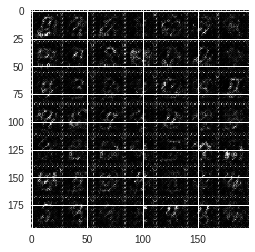

Epoch 1/2, 44.7%: d_loss=0.4143, g_loss=3.4713
Epoch 1/2, 45.1%: d_loss=0.4023, g_loss=3.7404
Epoch 1/2, 45.5%: d_loss=0.3972, g_loss=3.7347
Epoch 1/2, 45.9%: d_loss=0.3971, g_loss=3.6433
Epoch 1/2, 46.4%: d_loss=0.3898, g_loss=3.7719
Epoch 1/2, 46.8%: d_loss=0.3835, g_loss=3.9090
Epoch 1/2, 47.2%: d_loss=0.3819, g_loss=3.8815
Epoch 1/2, 47.6%: d_loss=0.3890, g_loss=3.6856
Epoch 1/2, 48.1%: d_loss=0.3866, g_loss=3.7605
Epoch 1/2, 48.5%: d_loss=0.3780, g_loss=4.0824
Epoch 1/2, 48.9%: d_loss=0.3737, g_loss=4.1597


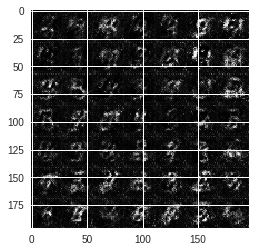

Epoch 1/2, 49.4%: d_loss=0.3754, g_loss=4.0603
Epoch 1/2, 49.8%: d_loss=0.3763, g_loss=4.2341
Epoch 1/2, 50.2%: d_loss=0.3716, g_loss=4.3187
Epoch 1/2, 50.6%: d_loss=0.3685, g_loss=4.3384
Epoch 1/2, 51.1%: d_loss=0.3737, g_loss=4.1459
Epoch 1/2, 51.5%: d_loss=0.3686, g_loss=4.3276
Epoch 1/2, 51.9%: d_loss=0.3657, g_loss=4.3757
Epoch 1/2, 52.4%: d_loss=0.3676, g_loss=4.2134
Epoch 1/2, 52.8%: d_loss=0.3690, g_loss=4.1420
Epoch 1/2, 53.2%: d_loss=0.3657, g_loss=4.3225
Epoch 1/2, 53.6%: d_loss=0.3662, g_loss=4.1954
Epoch 1/2, 54.1%: d_loss=0.3637, g_loss=4.6425


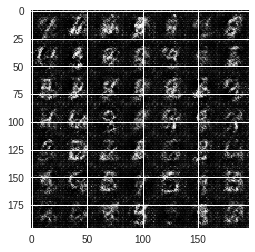

Epoch 1/2, 54.5%: d_loss=0.3608, g_loss=4.7007
Epoch 1/2, 54.9%: d_loss=0.3707, g_loss=4.4857
Epoch 1/2, 55.3%: d_loss=0.6882, g_loss=4.0276
Epoch 1/2, 55.8%: d_loss=1.1600, g_loss=4.6915
Epoch 1/2, 56.2%: d_loss=1.1222, g_loss=4.5363
Epoch 1/2, 56.6%: d_loss=1.0183, g_loss=4.0559
Epoch 1/2, 57.1%: d_loss=0.9057, g_loss=4.0377
Epoch 1/2, 57.5%: d_loss=0.8135, g_loss=3.8483
Epoch 1/2, 57.9%: d_loss=0.7353, g_loss=3.7851
Epoch 1/2, 58.3%: d_loss=0.6748, g_loss=3.6360
Epoch 1/2, 58.8%: d_loss=0.6353, g_loss=3.4254


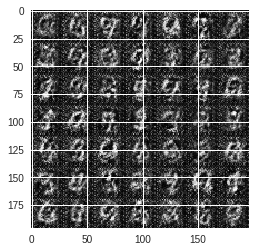

Epoch 1/2, 59.2%: d_loss=0.6354, g_loss=3.1226
Epoch 1/2, 59.6%: d_loss=0.6231, g_loss=3.5987
Epoch 1/2, 60.0%: d_loss=0.6053, g_loss=3.6870
Epoch 1/2, 60.5%: d_loss=0.5628, g_loss=4.1482
Epoch 1/2, 60.9%: d_loss=0.5232, g_loss=4.3137
Epoch 1/2, 61.3%: d_loss=0.4935, g_loss=4.2228
Epoch 1/2, 61.8%: d_loss=0.4817, g_loss=3.9306
Epoch 1/2, 62.2%: d_loss=0.4759, g_loss=3.6758
Epoch 1/2, 62.6%: d_loss=0.4516, g_loss=4.0226
Epoch 1/2, 63.0%: d_loss=0.4303, g_loss=4.4495
Epoch 1/2, 63.5%: d_loss=0.4152, g_loss=4.4920
Epoch 1/2, 63.9%: d_loss=0.4093, g_loss=4.2631


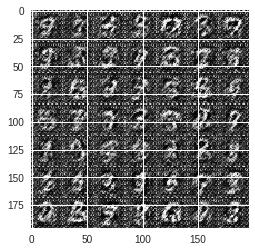

Epoch 1/2, 64.3%: d_loss=0.3997, g_loss=4.3093
Epoch 1/2, 64.7%: d_loss=0.3901, g_loss=4.3398
Epoch 1/2, 65.2%: d_loss=0.3817, g_loss=4.5864
Epoch 1/2, 65.6%: d_loss=0.3779, g_loss=4.4614
Epoch 1/2, 66.0%: d_loss=0.3794, g_loss=4.3900
Epoch 1/2, 66.5%: d_loss=0.3719, g_loss=4.7626
Epoch 1/2, 66.9%: d_loss=0.3706, g_loss=4.7374
Epoch 1/2, 67.3%: d_loss=0.3667, g_loss=5.0375
Epoch 1/2, 67.7%: d_loss=0.3661, g_loss=4.8650
Epoch 1/2, 68.2%: d_loss=0.3617, g_loss=4.9462
Epoch 1/2, 68.6%: d_loss=0.3579, g_loss=5.0067


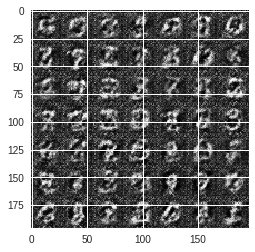

Epoch 1/2, 69.0%: d_loss=0.3665, g_loss=4.6535
Epoch 1/2, 69.4%: d_loss=0.3732, g_loss=4.4321
Epoch 1/2, 69.9%: d_loss=0.3722, g_loss=4.3879
Epoch 1/2, 70.3%: d_loss=0.3680, g_loss=4.5103
Epoch 1/2, 70.7%: d_loss=0.3639, g_loss=4.6270
Epoch 1/2, 71.2%: d_loss=0.3630, g_loss=4.5247
Epoch 1/2, 71.6%: d_loss=0.3633, g_loss=4.4417
Epoch 1/2, 72.0%: d_loss=0.3639, g_loss=5.0785
Epoch 1/2, 72.4%: d_loss=0.3609, g_loss=5.1323
Epoch 1/2, 72.9%: d_loss=0.3591, g_loss=5.0053
Epoch 1/2, 73.3%: d_loss=0.3548, g_loss=5.2424
Epoch 1/2, 73.7%: d_loss=0.4029, g_loss=4.9442


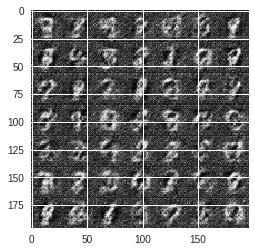

Epoch 1/2, 74.1%: d_loss=1.3215, g_loss=5.3006
Epoch 1/2, 74.6%: d_loss=1.2294, g_loss=4.5318
Epoch 1/2, 75.0%: d_loss=1.2081, g_loss=4.4762
Epoch 1/2, 75.4%: d_loss=1.0565, g_loss=4.4365
Epoch 1/2, 75.9%: d_loss=0.9576, g_loss=3.9911
Epoch 1/2, 76.3%: d_loss=0.9367, g_loss=3.5112
Epoch 1/2, 76.7%: d_loss=0.9393, g_loss=3.4898
Epoch 1/2, 77.1%: d_loss=1.0692, g_loss=3.8445
Epoch 1/2, 77.6%: d_loss=1.0005, g_loss=3.4137
Epoch 1/2, 78.0%: d_loss=0.9167, g_loss=3.2589
Epoch 1/2, 78.4%: d_loss=0.8153, g_loss=3.3571


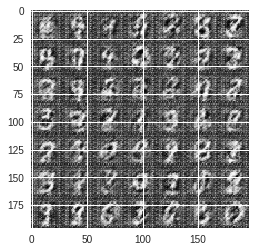

Epoch 1/2, 78.8%: d_loss=0.7879, g_loss=3.2280
Epoch 1/2, 79.3%: d_loss=0.7744, g_loss=3.6976
Epoch 1/2, 79.7%: d_loss=0.6987, g_loss=4.1195
Epoch 1/2, 80.1%: d_loss=0.6378, g_loss=4.0098
Epoch 1/2, 80.6%: d_loss=0.5977, g_loss=3.8101
Epoch 1/2, 81.0%: d_loss=0.5651, g_loss=3.8643
Epoch 1/2, 81.4%: d_loss=0.5243, g_loss=4.3049
Epoch 1/2, 81.8%: d_loss=0.4951, g_loss=4.1946
Epoch 1/2, 82.3%: d_loss=0.4788, g_loss=4.1268
Epoch 1/2, 82.7%: d_loss=0.4539, g_loss=4.3229
Epoch 1/2, 83.1%: d_loss=0.4380, g_loss=4.2371
Epoch 1/2, 83.5%: d_loss=0.4209, g_loss=4.6586


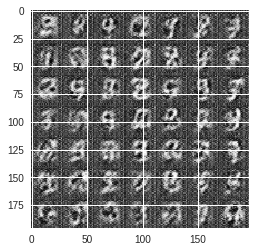

Epoch 1/2, 84.0%: d_loss=0.4158, g_loss=4.3616
Epoch 1/2, 84.4%: d_loss=0.4021, g_loss=4.9085
Epoch 1/2, 84.8%: d_loss=0.4140, g_loss=4.4481
Epoch 1/2, 85.3%: d_loss=0.5183, g_loss=4.4052
Epoch 1/2, 85.7%: d_loss=0.5052, g_loss=4.5720
Epoch 1/2, 86.1%: d_loss=0.5478, g_loss=4.2376
Epoch 1/2, 86.5%: d_loss=1.0298, g_loss=4.7275
Epoch 1/2, 87.0%: d_loss=1.1970, g_loss=4.0738
Epoch 1/2, 87.4%: d_loss=1.2361, g_loss=4.3029
Epoch 1/2, 87.8%: d_loss=1.1563, g_loss=4.0091
Epoch 1/2, 88.2%: d_loss=1.0286, g_loss=3.9119


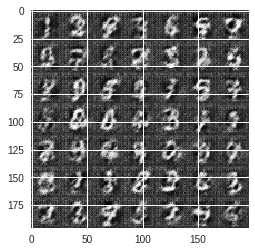

Epoch 1/2, 88.7%: d_loss=0.9547, g_loss=3.4949
Epoch 1/2, 89.1%: d_loss=0.9761, g_loss=3.0065
Epoch 1/2, 89.5%: d_loss=0.9011, g_loss=3.0914
Epoch 1/2, 90.0%: d_loss=0.7988, g_loss=3.2959
Epoch 1/2, 90.4%: d_loss=0.7236, g_loss=3.2691
Epoch 1/2, 90.8%: d_loss=0.7227, g_loss=2.9595
Epoch 1/2, 91.2%: d_loss=0.7910, g_loss=4.1404
Epoch 1/2, 91.7%: d_loss=0.8720, g_loss=4.3158
Epoch 1/2, 92.1%: d_loss=0.8477, g_loss=4.9135
Epoch 1/2, 92.5%: d_loss=0.7845, g_loss=4.5365
Epoch 1/2, 92.9%: d_loss=0.7029, g_loss=4.6913
Epoch 1/2, 93.4%: d_loss=0.6363, g_loss=4.8075


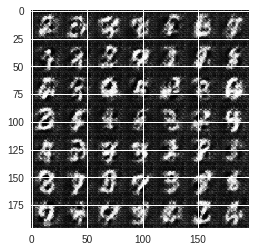

Epoch 1/2, 93.8%: d_loss=0.5928, g_loss=4.4548
Epoch 1/2, 94.2%: d_loss=0.6410, g_loss=3.9023
Epoch 1/2, 94.7%: d_loss=0.6499, g_loss=3.5585
Epoch 1/2, 95.1%: d_loss=0.5937, g_loss=4.5076
Epoch 1/2, 95.5%: d_loss=0.5477, g_loss=4.5875
Epoch 1/2, 95.9%: d_loss=0.5118, g_loss=4.4716
Epoch 1/2, 96.4%: d_loss=0.4970, g_loss=4.1189
Epoch 1/2, 96.8%: d_loss=0.5254, g_loss=4.2191
Epoch 1/2, 97.2%: d_loss=0.4989, g_loss=4.9904
Epoch 1/2, 97.6%: d_loss=0.4778, g_loss=4.8540
Epoch 1/2, 98.1%: d_loss=0.4764, g_loss=4.4323


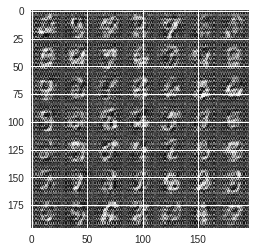

Epoch 1/2, 98.5%: d_loss=0.4649, g_loss=5.5869
Epoch 1/2, 98.9%: d_loss=0.4450, g_loss=5.5538
Epoch 1/2, 99.4%: d_loss=0.4270, g_loss=5.3854
Epoch 1/2, 99.8%: d_loss=0.4202, g_loss=5.2692


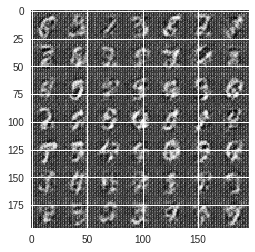

Epoch 1/2, 100.2%: d_loss=0.4173, g_loss=5.7050


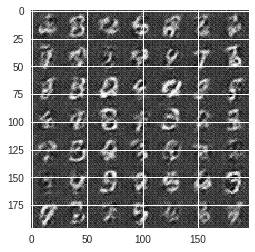

Epoch 2/2, 0.2%: d_loss=0.4107, g_loss=5.5698
Epoch 2/2, 0.6%: d_loss=0.4131, g_loss=5.0754
Epoch 2/2, 1.1%: d_loss=0.4128, g_loss=5.4561
Epoch 2/2, 1.5%: d_loss=0.4008, g_loss=5.8057
Epoch 2/2, 1.9%: d_loss=0.4001, g_loss=5.5029
Epoch 2/2, 2.4%: d_loss=0.4020, g_loss=5.5321
Epoch 2/2, 2.8%: d_loss=0.3981, g_loss=5.4722
Epoch 2/2, 3.2%: d_loss=0.4005, g_loss=5.6748
Epoch 2/2, 3.6%: d_loss=0.3949, g_loss=5.5943
Epoch 2/2, 4.1%: d_loss=0.3926, g_loss=5.3305
Epoch 2/2, 4.5%: d_loss=0.3884, g_loss=5.3359
Epoch 2/2, 4.9%: d_loss=0.4139, g_loss=5.1058


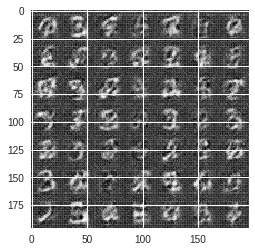

Epoch 2/2, 5.3%: d_loss=0.4251, g_loss=5.0998
Epoch 2/2, 5.8%: d_loss=0.4241, g_loss=5.0786
Epoch 2/2, 6.2%: d_loss=0.4097, g_loss=5.0764
Epoch 2/2, 6.6%: d_loss=0.4021, g_loss=4.8233
Epoch 2/2, 7.1%: d_loss=0.3974, g_loss=4.7536
Epoch 2/2, 7.5%: d_loss=0.3862, g_loss=5.2352
Epoch 2/2, 7.9%: d_loss=0.3830, g_loss=5.0532
Epoch 2/2, 8.3%: d_loss=0.3840, g_loss=5.2797
Epoch 2/2, 8.8%: d_loss=0.4062, g_loss=4.7905
Epoch 2/2, 9.2%: d_loss=0.5797, g_loss=5.1845
Epoch 2/2, 9.6%: d_loss=0.5829, g_loss=5.2525


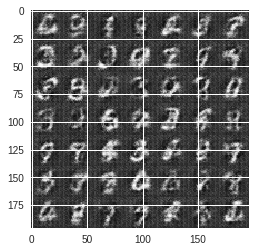

Epoch 2/2, 10.0%: d_loss=0.6037, g_loss=4.5870
Epoch 2/2, 10.5%: d_loss=0.7944, g_loss=3.9602
Epoch 2/2, 10.9%: d_loss=1.0186, g_loss=4.5947
Epoch 2/2, 11.3%: d_loss=0.9515, g_loss=4.1338
Epoch 2/2, 11.8%: d_loss=0.9030, g_loss=3.7209
Epoch 2/2, 12.2%: d_loss=0.7982, g_loss=4.0102
Epoch 2/2, 12.6%: d_loss=0.8086, g_loss=3.8476
Epoch 2/2, 13.0%: d_loss=0.7377, g_loss=3.7425
Epoch 2/2, 13.5%: d_loss=1.2405, g_loss=3.7794
Epoch 2/2, 13.9%: d_loss=1.3225, g_loss=3.2335
Epoch 2/2, 14.3%: d_loss=1.2937, g_loss=3.4625
Epoch 2/2, 14.7%: d_loss=1.2452, g_loss=3.0982


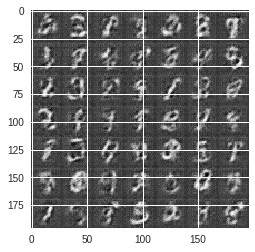

Epoch 2/2, 15.2%: d_loss=1.2686, g_loss=2.6858
Epoch 2/2, 15.6%: d_loss=1.3131, g_loss=2.3347
Epoch 2/2, 16.0%: d_loss=1.3515, g_loss=2.0251
Epoch 2/2, 16.5%: d_loss=1.3163, g_loss=1.8387
Epoch 2/2, 16.9%: d_loss=1.1526, g_loss=2.2450
Epoch 2/2, 17.3%: d_loss=1.1751, g_loss=2.0980
Epoch 2/2, 17.7%: d_loss=1.1681, g_loss=1.8510
Epoch 2/2, 18.2%: d_loss=1.1038, g_loss=1.9152
Epoch 2/2, 18.6%: d_loss=0.9682, g_loss=2.1915
Epoch 2/2, 19.0%: d_loss=0.9895, g_loss=2.1573
Epoch 2/2, 19.4%: d_loss=1.0430, g_loss=1.9899


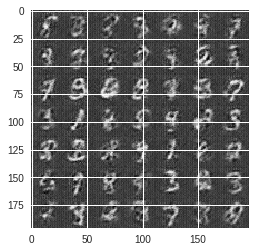

Epoch 2/2, 19.9%: d_loss=0.9722, g_loss=1.9382
Epoch 2/2, 20.3%: d_loss=0.8592, g_loss=2.4945
Epoch 2/2, 20.7%: d_loss=0.9506, g_loss=2.6575
Epoch 2/2, 21.2%: d_loss=1.0095, g_loss=2.4076
Epoch 2/2, 21.6%: d_loss=1.0018, g_loss=2.6131
Epoch 2/2, 22.0%: d_loss=1.0627, g_loss=2.3272
Epoch 2/2, 22.4%: d_loss=1.0136, g_loss=2.1975
Epoch 2/2, 22.9%: d_loss=0.9093, g_loss=2.3548
Epoch 2/2, 23.3%: d_loss=0.8452, g_loss=2.2954
Epoch 2/2, 23.7%: d_loss=0.7771, g_loss=2.3658
Epoch 2/2, 24.1%: d_loss=0.7147, g_loss=2.4384
Epoch 2/2, 24.6%: d_loss=0.7059, g_loss=2.3971


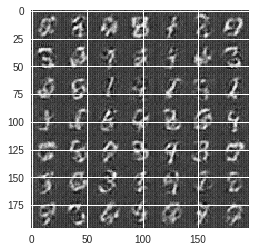

Epoch 2/2, 25.0%: d_loss=0.9283, g_loss=2.4132
Epoch 2/2, 25.4%: d_loss=0.9198, g_loss=2.3384
Epoch 2/2, 25.9%: d_loss=0.8975, g_loss=2.2626
Epoch 2/2, 26.3%: d_loss=0.8312, g_loss=2.2341
Epoch 2/2, 26.7%: d_loss=0.7895, g_loss=2.2968
Epoch 2/2, 27.1%: d_loss=0.7394, g_loss=2.3445
Epoch 2/2, 27.6%: d_loss=0.7311, g_loss=2.4299
Epoch 2/2, 28.0%: d_loss=0.7979, g_loss=2.4092
Epoch 2/2, 28.4%: d_loss=0.7371, g_loss=2.3851
Epoch 2/2, 28.8%: d_loss=0.7704, g_loss=2.5530
Epoch 2/2, 29.3%: d_loss=0.8272, g_loss=2.5670


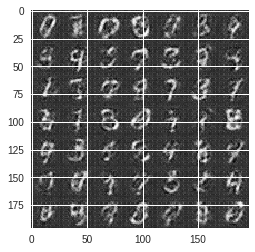

Epoch 2/2, 29.7%: d_loss=0.7951, g_loss=2.6276
Epoch 2/2, 30.1%: d_loss=0.7175, g_loss=2.8918
Epoch 2/2, 30.6%: d_loss=0.6922, g_loss=2.8284
Epoch 2/2, 31.0%: d_loss=0.6647, g_loss=2.6694
Epoch 2/2, 31.4%: d_loss=0.6544, g_loss=2.6212
Epoch 2/2, 31.8%: d_loss=0.6729, g_loss=2.6529
Epoch 2/2, 32.3%: d_loss=0.6611, g_loss=2.8310
Epoch 2/2, 32.7%: d_loss=0.6156, g_loss=2.9112
Epoch 2/2, 33.1%: d_loss=0.6970, g_loss=2.9083
Epoch 2/2, 33.5%: d_loss=0.8185, g_loss=2.7251
Epoch 2/2, 34.0%: d_loss=0.8385, g_loss=2.6461
Epoch 2/2, 34.4%: d_loss=0.8127, g_loss=3.2008


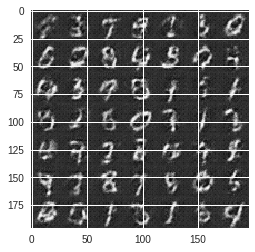

Epoch 2/2, 34.8%: d_loss=0.7764, g_loss=3.0555
Epoch 2/2, 35.3%: d_loss=0.7709, g_loss=2.7871
Epoch 2/2, 35.7%: d_loss=0.7990, g_loss=2.5345
Epoch 2/2, 36.1%: d_loss=0.7424, g_loss=2.8986
Epoch 2/2, 36.5%: d_loss=0.8170, g_loss=2.9348
Epoch 2/2, 37.0%: d_loss=0.8291, g_loss=2.7705
Epoch 2/2, 37.4%: d_loss=0.8215, g_loss=2.7932
Epoch 2/2, 37.8%: d_loss=0.7557, g_loss=2.7948
Epoch 2/2, 38.2%: d_loss=0.7402, g_loss=2.6874
Epoch 2/2, 38.7%: d_loss=0.7573, g_loss=2.9053
Epoch 2/2, 39.1%: d_loss=0.7922, g_loss=2.6635


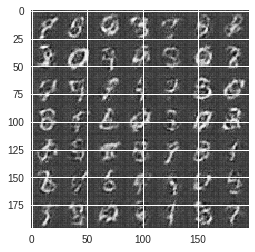

Epoch 2/2, 39.5%: d_loss=0.7880, g_loss=2.8793
Epoch 2/2, 40.0%: d_loss=0.7920, g_loss=2.8038
Epoch 2/2, 40.4%: d_loss=0.7921, g_loss=2.7595
Epoch 2/2, 40.8%: d_loss=0.7894, g_loss=2.7049
Epoch 2/2, 41.2%: d_loss=0.7122, g_loss=3.3733
Epoch 2/2, 41.7%: d_loss=0.6825, g_loss=3.2061
Epoch 2/2, 42.1%: d_loss=0.6361, g_loss=3.3128
Epoch 2/2, 42.5%: d_loss=0.6397, g_loss=3.0948
Epoch 2/2, 42.9%: d_loss=0.6069, g_loss=3.2538
Epoch 2/2, 43.4%: d_loss=0.5801, g_loss=3.4095
Epoch 2/2, 43.8%: d_loss=0.5502, g_loss=3.4477
Epoch 2/2, 44.2%: d_loss=0.5170, g_loss=3.5997


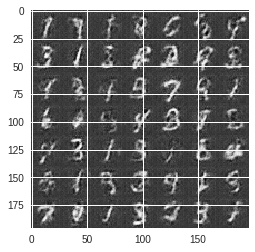

Epoch 2/2, 44.7%: d_loss=0.5875, g_loss=3.6227
Epoch 2/2, 45.1%: d_loss=0.7323, g_loss=3.4529
Epoch 2/2, 45.5%: d_loss=0.7981, g_loss=3.1478
Epoch 2/2, 45.9%: d_loss=0.7819, g_loss=3.4169
Epoch 2/2, 46.4%: d_loss=0.8045, g_loss=3.3602
Epoch 2/2, 46.8%: d_loss=0.7900, g_loss=3.0671
Epoch 2/2, 47.2%: d_loss=0.7422, g_loss=3.1440
Epoch 2/2, 47.6%: d_loss=0.7663, g_loss=2.9757
Epoch 2/2, 48.1%: d_loss=0.7486, g_loss=2.7128
Epoch 2/2, 48.5%: d_loss=0.7072, g_loss=3.0338
Epoch 2/2, 48.9%: d_loss=0.7598, g_loss=3.0466


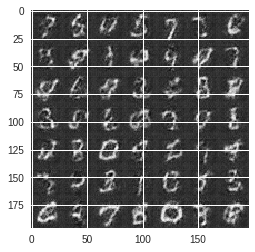

Epoch 2/2, 49.4%: d_loss=0.7277, g_loss=2.7853
Epoch 2/2, 49.8%: d_loss=0.6711, g_loss=3.0747
Epoch 2/2, 50.2%: d_loss=0.7173, g_loss=2.9778
Epoch 2/2, 50.6%: d_loss=0.6823, g_loss=3.1314
Epoch 2/2, 51.1%: d_loss=0.6537, g_loss=3.0781
Epoch 2/2, 51.5%: d_loss=0.6095, g_loss=3.4345
Epoch 2/2, 51.9%: d_loss=0.6040, g_loss=3.2705
Epoch 2/2, 52.4%: d_loss=0.5839, g_loss=3.0857
Epoch 2/2, 52.8%: d_loss=0.5447, g_loss=3.2636
Epoch 2/2, 53.2%: d_loss=0.5437, g_loss=3.2322
Epoch 2/2, 53.6%: d_loss=0.5551, g_loss=3.6006
Epoch 2/2, 54.1%: d_loss=0.8034, g_loss=3.6487


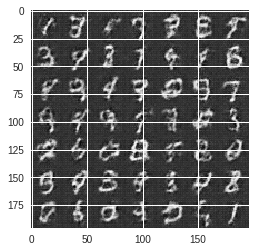

Epoch 2/2, 54.5%: d_loss=0.7888, g_loss=3.1943
Epoch 2/2, 54.9%: d_loss=0.7442, g_loss=3.1889
Epoch 2/2, 55.3%: d_loss=0.7844, g_loss=2.9555
Epoch 2/2, 55.8%: d_loss=0.7486, g_loss=2.7253
Epoch 2/2, 56.2%: d_loss=0.6855, g_loss=2.9198
Epoch 2/2, 56.6%: d_loss=0.6626, g_loss=2.8702
Epoch 2/2, 57.1%: d_loss=0.7242, g_loss=2.8242
Epoch 2/2, 57.5%: d_loss=0.6932, g_loss=2.9591
Epoch 2/2, 57.9%: d_loss=0.6515, g_loss=3.1654
Epoch 2/2, 58.3%: d_loss=0.6349, g_loss=3.0709
Epoch 2/2, 58.8%: d_loss=0.6133, g_loss=3.1944


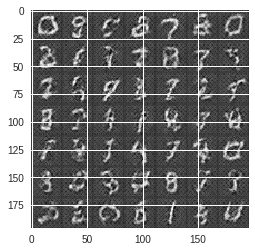

Epoch 2/2, 59.2%: d_loss=0.7703, g_loss=3.3099
Epoch 2/2, 59.6%: d_loss=0.8190, g_loss=2.9879
Epoch 2/2, 60.0%: d_loss=0.8242, g_loss=2.7176
Epoch 2/2, 60.5%: d_loss=0.7845, g_loss=3.2241
Epoch 2/2, 60.9%: d_loss=0.7581, g_loss=3.1268
Epoch 2/2, 61.3%: d_loss=0.7380, g_loss=2.8939
Epoch 2/2, 61.8%: d_loss=0.6968, g_loss=2.8828
Epoch 2/2, 62.2%: d_loss=0.6447, g_loss=2.8899
Epoch 2/2, 62.6%: d_loss=0.5921, g_loss=3.1079
Epoch 2/2, 63.0%: d_loss=0.5995, g_loss=3.0684
Epoch 2/2, 63.5%: d_loss=0.6036, g_loss=3.4047
Epoch 2/2, 63.9%: d_loss=0.5653, g_loss=3.4126


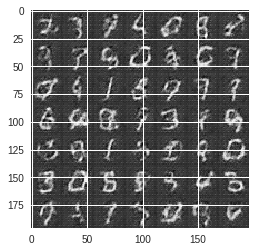

Epoch 2/2, 64.3%: d_loss=0.5300, g_loss=3.4903
Epoch 2/2, 64.7%: d_loss=0.5204, g_loss=3.3923
Epoch 2/2, 65.2%: d_loss=0.4974, g_loss=3.3783
Epoch 2/2, 65.6%: d_loss=0.4831, g_loss=3.3081
Epoch 2/2, 66.0%: d_loss=0.4939, g_loss=3.3485
Epoch 2/2, 66.5%: d_loss=0.5006, g_loss=3.2977
Epoch 2/2, 66.9%: d_loss=0.4836, g_loss=3.4267
Epoch 2/2, 67.3%: d_loss=0.4611, g_loss=3.8077
Epoch 2/2, 67.7%: d_loss=0.5932, g_loss=4.0319
Epoch 2/2, 68.2%: d_loss=0.6524, g_loss=3.4967
Epoch 2/2, 68.6%: d_loss=0.6528, g_loss=3.3123


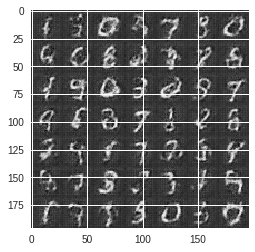

Epoch 2/2, 69.0%: d_loss=0.6358, g_loss=3.0601
Epoch 2/2, 69.4%: d_loss=0.6186, g_loss=2.8772
Epoch 2/2, 69.9%: d_loss=0.5870, g_loss=2.9457
Epoch 2/2, 70.3%: d_loss=0.5536, g_loss=3.0687
Epoch 2/2, 70.7%: d_loss=0.5697, g_loss=3.0039
Epoch 2/2, 71.2%: d_loss=0.6455, g_loss=3.4475
Epoch 2/2, 71.6%: d_loss=0.9731, g_loss=3.2779
Epoch 2/2, 72.0%: d_loss=0.9713, g_loss=2.9162
Epoch 2/2, 72.4%: d_loss=0.9172, g_loss=2.7820
Epoch 2/2, 72.9%: d_loss=0.8779, g_loss=2.5272
Epoch 2/2, 73.3%: d_loss=0.8950, g_loss=2.3428
Epoch 2/2, 73.7%: d_loss=0.8475, g_loss=2.5098


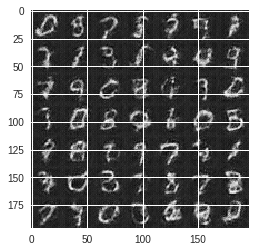

Epoch 2/2, 74.1%: d_loss=0.7843, g_loss=2.6447
Epoch 2/2, 74.6%: d_loss=0.7328, g_loss=2.8492
Epoch 2/2, 75.0%: d_loss=0.6642, g_loss=3.2789
Epoch 2/2, 75.4%: d_loss=0.6907, g_loss=2.9902
Epoch 2/2, 75.9%: d_loss=0.6846, g_loss=2.8183
Epoch 2/2, 76.3%: d_loss=0.6412, g_loss=2.7593
Epoch 2/2, 76.7%: d_loss=0.5994, g_loss=3.1828
Epoch 2/2, 77.1%: d_loss=0.5791, g_loss=3.0945
Epoch 2/2, 77.6%: d_loss=0.5563, g_loss=3.0506
Epoch 2/2, 78.0%: d_loss=0.5347, g_loss=3.3110
Epoch 2/2, 78.4%: d_loss=0.5010, g_loss=3.5341


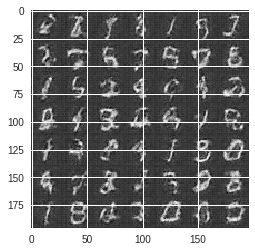

Epoch 2/2, 78.8%: d_loss=0.6502, g_loss=3.4029
Epoch 2/2, 79.3%: d_loss=0.7788, g_loss=3.6032
Epoch 2/2, 79.7%: d_loss=0.7325, g_loss=3.2746
Epoch 2/2, 80.1%: d_loss=0.8020, g_loss=3.1544
Epoch 2/2, 80.6%: d_loss=0.8256, g_loss=2.7280
Epoch 2/2, 81.0%: d_loss=0.8562, g_loss=2.9937
Epoch 2/2, 81.4%: d_loss=0.8167, g_loss=3.1585
Epoch 2/2, 81.8%: d_loss=0.8196, g_loss=2.7858
Epoch 2/2, 82.3%: d_loss=0.8450, g_loss=2.5831
Epoch 2/2, 82.7%: d_loss=0.7655, g_loss=2.7011
Epoch 2/2, 83.1%: d_loss=0.7668, g_loss=2.4941
Epoch 2/2, 83.5%: d_loss=0.7193, g_loss=2.6468


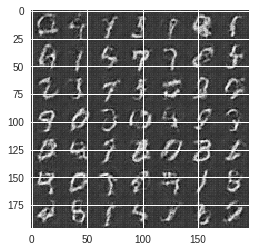

Epoch 2/2, 84.0%: d_loss=0.6737, g_loss=2.6269
Epoch 2/2, 84.4%: d_loss=0.6209, g_loss=3.1784
Epoch 2/2, 84.8%: d_loss=0.6757, g_loss=3.0332
Epoch 2/2, 85.3%: d_loss=0.6890, g_loss=3.4159
Epoch 2/2, 85.7%: d_loss=0.6386, g_loss=3.3130
Epoch 2/2, 86.1%: d_loss=0.5915, g_loss=3.3176
Epoch 2/2, 86.5%: d_loss=0.5789, g_loss=3.1065
Epoch 2/2, 87.0%: d_loss=0.5744, g_loss=2.8858
Epoch 2/2, 87.4%: d_loss=0.5469, g_loss=3.2014
Epoch 2/2, 87.8%: d_loss=0.5116, g_loss=3.4292
Epoch 2/2, 88.2%: d_loss=0.5319, g_loss=3.2845


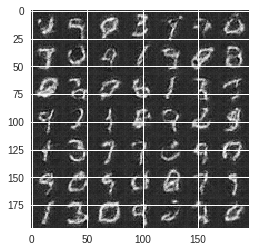

Epoch 2/2, 88.7%: d_loss=0.6104, g_loss=3.0611
Epoch 2/2, 89.1%: d_loss=0.5662, g_loss=3.1501
Epoch 2/2, 89.5%: d_loss=0.5286, g_loss=3.3239
Epoch 2/2, 90.0%: d_loss=0.5337, g_loss=3.1932
Epoch 2/2, 90.4%: d_loss=0.5307, g_loss=3.0347
Epoch 2/2, 90.8%: d_loss=0.4996, g_loss=3.3266
Epoch 2/2, 91.2%: d_loss=0.4693, g_loss=3.9297
Epoch 2/2, 91.7%: d_loss=0.5046, g_loss=3.8448
Epoch 2/2, 92.1%: d_loss=0.5618, g_loss=3.6485
Epoch 2/2, 92.5%: d_loss=0.5611, g_loss=3.9255
Epoch 2/2, 92.9%: d_loss=0.5302, g_loss=3.7774
Epoch 2/2, 93.4%: d_loss=0.5510, g_loss=3.6745


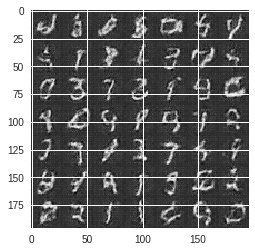

Epoch 2/2, 93.8%: d_loss=0.5188, g_loss=3.6662
Epoch 2/2, 94.2%: d_loss=0.6557, g_loss=3.8583
Epoch 2/2, 94.7%: d_loss=0.7504, g_loss=3.5111
Epoch 2/2, 95.1%: d_loss=1.0327, g_loss=3.7470
Epoch 2/2, 95.5%: d_loss=1.1277, g_loss=3.4081
Epoch 2/2, 95.9%: d_loss=1.1125, g_loss=3.0306
Epoch 2/2, 96.4%: d_loss=1.0578, g_loss=2.7812
Epoch 2/2, 96.8%: d_loss=1.0242, g_loss=2.4966
Epoch 2/2, 97.2%: d_loss=0.9699, g_loss=2.2840
Epoch 2/2, 97.6%: d_loss=0.8726, g_loss=2.6001
Epoch 2/2, 98.1%: d_loss=0.9594, g_loss=2.8923


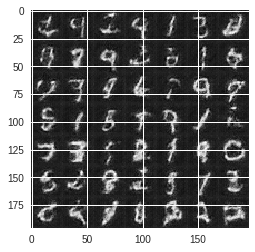

Epoch 2/2, 98.5%: d_loss=0.8971, g_loss=2.6384
Epoch 2/2, 98.9%: d_loss=0.8458, g_loss=2.4913
Epoch 2/2, 99.4%: d_loss=0.7999, g_loss=2.3582
Epoch 2/2, 99.8%: d_loss=0.7397, g_loss=2.3696


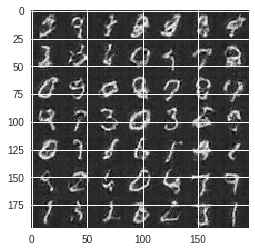

Epoch 2/2, 100.2%: d_loss=0.7150, g_loss=2.3785


In [17]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

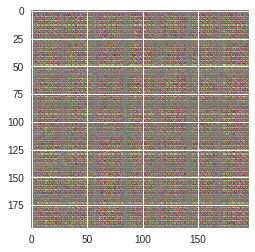

Epoch 1/1, 0.0%: d_loss=0.6419, g_loss=0.0004
Epoch 1/1, 0.5%: d_loss=1.0668, g_loss=1.6169
Epoch 1/1, 1.0%: d_loss=1.2386, g_loss=1.0648
Epoch 1/1, 1.5%: d_loss=0.7756, g_loss=1.6934
Epoch 1/1, 2.0%: d_loss=0.5298, g_loss=2.8522
Epoch 1/1, 2.5%: d_loss=0.4025, g_loss=3.6665
Epoch 1/1, 3.0%: d_loss=0.3993, g_loss=4.0046
Epoch 1/1, 3.4%: d_loss=0.4002, g_loss=4.3607
Epoch 1/1, 3.9%: d_loss=0.4496, g_loss=4.8556
Epoch 1/1, 4.4%: d_loss=0.3614, g_loss=5.5561
Epoch 1/1, 4.9%: d_loss=0.3627, g_loss=5.8372


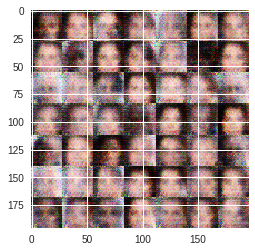

Epoch 1/1, 5.4%: d_loss=0.4123, g_loss=5.6135
Epoch 1/1, 5.9%: d_loss=0.3790, g_loss=6.9457
Epoch 1/1, 6.4%: d_loss=0.3510, g_loss=7.2408
Epoch 1/1, 6.9%: d_loss=0.4112, g_loss=6.9758
Epoch 1/1, 7.4%: d_loss=1.1279, g_loss=4.9226
Epoch 1/1, 7.9%: d_loss=0.7147, g_loss=3.8820
Epoch 1/1, 8.3%: d_loss=0.7796, g_loss=3.7726
Epoch 1/1, 8.8%: d_loss=0.6568, g_loss=3.1183
Epoch 1/1, 9.3%: d_loss=0.6813, g_loss=3.5375
Epoch 1/1, 9.8%: d_loss=0.6081, g_loss=3.5620


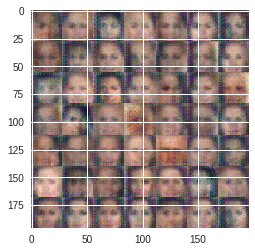

Epoch 1/1, 10.3%: d_loss=0.7613, g_loss=2.5050
Epoch 1/1, 10.8%: d_loss=0.5075, g_loss=3.7930
Epoch 1/1, 11.3%: d_loss=0.6606, g_loss=4.2316
Epoch 1/1, 11.8%: d_loss=0.4545, g_loss=5.2988
Epoch 1/1, 12.3%: d_loss=1.0527, g_loss=4.4012
Epoch 1/1, 12.7%: d_loss=0.9473, g_loss=2.3113
Epoch 1/1, 13.2%: d_loss=0.6083, g_loss=2.9695
Epoch 1/1, 13.7%: d_loss=0.5020, g_loss=4.3743
Epoch 1/1, 14.2%: d_loss=0.3943, g_loss=5.0940
Epoch 1/1, 14.7%: d_loss=1.0749, g_loss=3.4332


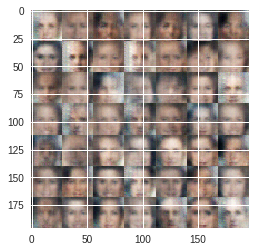

Epoch 1/1, 15.2%: d_loss=0.5539, g_loss=4.2784
Epoch 1/1, 15.7%: d_loss=0.4747, g_loss=4.3898
Epoch 1/1, 16.2%: d_loss=1.4285, g_loss=2.0579
Epoch 1/1, 16.7%: d_loss=0.5549, g_loss=3.0967
Epoch 1/1, 17.2%: d_loss=0.4355, g_loss=4.3852
Epoch 1/1, 17.6%: d_loss=0.4130, g_loss=5.3496
Epoch 1/1, 18.1%: d_loss=0.4268, g_loss=4.9413
Epoch 1/1, 18.6%: d_loss=0.4540, g_loss=4.3982
Epoch 1/1, 19.1%: d_loss=0.9750, g_loss=3.6944
Epoch 1/1, 19.6%: d_loss=0.4786, g_loss=4.6219


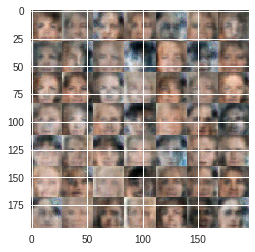

Epoch 1/1, 20.1%: d_loss=0.3936, g_loss=5.7651
Epoch 1/1, 20.6%: d_loss=0.7111, g_loss=3.3257
Epoch 1/1, 21.1%: d_loss=0.6541, g_loss=3.8379
Epoch 1/1, 21.6%: d_loss=0.5960, g_loss=3.9662
Epoch 1/1, 22.1%: d_loss=0.3974, g_loss=5.3428
Epoch 1/1, 22.5%: d_loss=0.4306, g_loss=4.9267
Epoch 1/1, 23.0%: d_loss=0.4338, g_loss=5.4501
Epoch 1/1, 23.5%: d_loss=0.4762, g_loss=4.8253
Epoch 1/1, 24.0%: d_loss=0.4094, g_loss=4.3309
Epoch 1/1, 24.5%: d_loss=0.4462, g_loss=4.5070


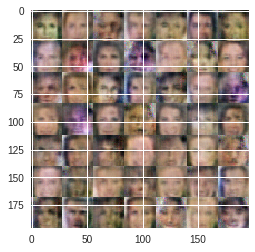

Epoch 1/1, 25.0%: d_loss=0.4086, g_loss=5.9676
Epoch 1/1, 25.5%: d_loss=0.3869, g_loss=6.1582
Epoch 1/1, 26.0%: d_loss=0.5101, g_loss=4.4415
Epoch 1/1, 26.5%: d_loss=0.6062, g_loss=4.9098
Epoch 1/1, 26.9%: d_loss=0.4130, g_loss=5.4797
Epoch 1/1, 27.4%: d_loss=0.4609, g_loss=5.6098
Epoch 1/1, 27.9%: d_loss=0.5238, g_loss=4.7632
Epoch 1/1, 28.4%: d_loss=0.5178, g_loss=4.8260
Epoch 1/1, 28.9%: d_loss=0.3888, g_loss=5.8936
Epoch 1/1, 29.4%: d_loss=0.4585, g_loss=5.3444
Epoch 1/1, 29.9%: d_loss=0.4306, g_loss=5.0787


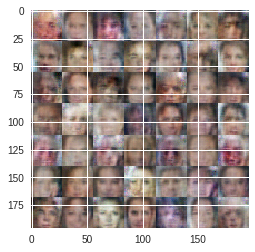

Epoch 1/1, 30.4%: d_loss=0.5936, g_loss=5.0000
Epoch 1/1, 30.9%: d_loss=0.4133, g_loss=5.1895
Epoch 1/1, 31.4%: d_loss=0.4503, g_loss=5.9673
Epoch 1/1, 31.8%: d_loss=0.4307, g_loss=5.9854
Epoch 1/1, 32.3%: d_loss=0.3788, g_loss=5.8055
Epoch 1/1, 32.8%: d_loss=0.4945, g_loss=5.2135
Epoch 1/1, 33.3%: d_loss=0.4813, g_loss=5.5787
Epoch 1/1, 33.8%: d_loss=0.4251, g_loss=5.8607
Epoch 1/1, 34.3%: d_loss=0.3898, g_loss=6.0212
Epoch 1/1, 34.8%: d_loss=0.4432, g_loss=5.2051


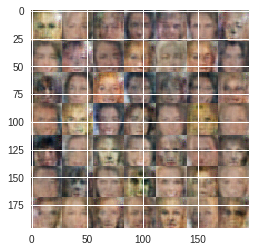

Epoch 1/1, 35.3%: d_loss=0.4211, g_loss=5.5451
Epoch 1/1, 35.8%: d_loss=0.6416, g_loss=5.3750
Epoch 1/1, 36.3%: d_loss=0.5832, g_loss=5.7494
Epoch 1/1, 36.7%: d_loss=0.3773, g_loss=8.1726
Epoch 1/1, 37.2%: d_loss=0.3636, g_loss=5.4087
Epoch 1/1, 37.7%: d_loss=0.3997, g_loss=5.5343
Epoch 1/1, 38.2%: d_loss=0.3836, g_loss=5.4397
Epoch 1/1, 38.7%: d_loss=0.8109, g_loss=3.8479
Epoch 1/1, 39.2%: d_loss=0.5102, g_loss=4.1148
Epoch 1/1, 39.7%: d_loss=0.4082, g_loss=5.2098


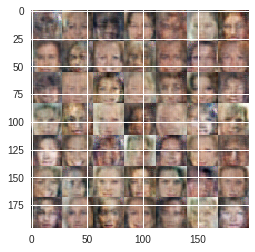

Epoch 1/1, 40.2%: d_loss=0.3832, g_loss=5.5458
Epoch 1/1, 40.7%: d_loss=0.4674, g_loss=5.3815
Epoch 1/1, 41.1%: d_loss=0.5289, g_loss=5.2225
Epoch 1/1, 41.6%: d_loss=0.4891, g_loss=6.9682
Epoch 1/1, 42.1%: d_loss=0.4056, g_loss=4.8827
Epoch 1/1, 42.6%: d_loss=1.0081, g_loss=3.4131
Epoch 1/1, 43.1%: d_loss=0.5162, g_loss=4.5859
Epoch 1/1, 43.6%: d_loss=0.4234, g_loss=6.3436
Epoch 1/1, 44.1%: d_loss=0.6028, g_loss=5.4033
Epoch 1/1, 44.6%: d_loss=0.4499, g_loss=6.8834


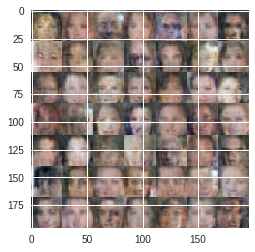

Epoch 1/1, 45.1%: d_loss=0.3888, g_loss=6.7413
Epoch 1/1, 45.6%: d_loss=0.3888, g_loss=6.9447


KeyboardInterrupt: ignored

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.